<a href="https://colab.research.google.com/github/moist234/ECON3916-Statistical-Machine-Learning/blob/main/Assignment3/Econ_3916_Assignment_3_Causal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [39]:
np.random.seed(42)
zeros = np.zeros(100)
tips = np.random.exponential(scale=5.0, size =150)
driver_tips = np.concatenate([zeros, tips])

print(f"Sample Size:: {len(driver_tips)}")
print(f"Sample Median: ${np.median(driver_tips):.2f}")
print(f"Zero-tip Proportion:  {np.mean(driver_tips):.2f}")


Sample Size:: 250
Sample Median: $0.76
Zero-tip Proportion:  2.77


In [40]:
np.random.seed(42)
n_bootstrap = 10_000
bootstrap_medians = np.empty(n_bootstrap)

for i in range(n_bootstrap):
  resample = np.random.choice(driver_tips, size=len(driver_tips), replace=True)
  bootstrap_medians[i] = np.median(resample)

  ci_lower = np.percentile(bootstrap_medians, 2.5)
  ci_upper = np.percentile(bootstrap_medians, 97.5)
print(f"Bootsrap 95% ci: [${ci_lower:.2f}, ${ci_upper:.2f}]")
print(f"Observed Median: ${np.median(driver_tips):.2f}")
print(f"The CI is asymetric. It goes further right because of exponential skew")

Bootsrap 95% ci: [$0.26, $1.36]
Observed Median: $0.76
The CI is asymetric. It goes further right because of exponential skew


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

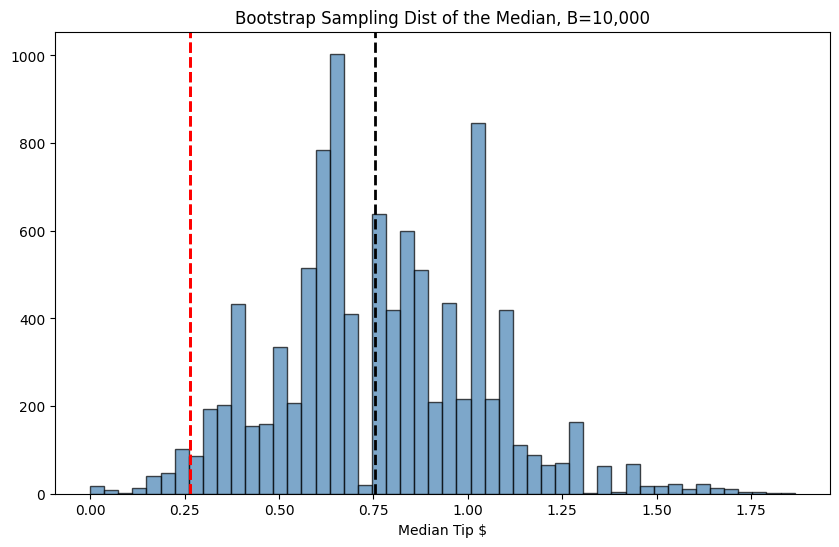

In [41]:
from matplotlib import lines
plt.figure(figsize=(10,6))
plt.hist(bootstrap_medians,bins=50,edgecolor='black',alpha=0.7,color='steelblue')
plt.axvline(ci_lower, color='red', linestyle='--', linewidth=2, label=f'2.5th = ${ci_lower:.2f}')
plt.axvline(ci_lower, color='red', linestyle='--', linewidth=2, label=f'97.5th = ${ci_upper:.2f}')
plt.axvline(np.median(driver_tips), color='black', linestyle='--', linewidth=2, label=f'Median = ${np.median(driver_tips):.2f}')

plt.title('Bootstrap Sampling Dist of the Median, B=10,000')
plt.xlabel('Median Tip $')
plt.ylabel


In [42]:
# Phase 2
# 2.1
np.random.seed(42)
control = np.random.normal(loc=35, scale=5, size=100)
treatment = np.random.lognormal(mean=3.4, sigma=0.4, size=500)

observed_diff = control.mean() - treatment.mean()
print(f"Mean Control: {control.mean():.2f}")
print(f"Observed Difference: ${observed_diff:.2f}")

Mean Control: 34.48
Observed Difference: $1.97


In [43]:
# 2.2
np.random.seed(42)
combined = np.concatenate([control, treatment])
n_permutations = 5_000
perm_diffs = np.empty(n_permutations)

for i in range(n_permutations):
  shuffled = np.random.permutation(combined)
  perm_control = shuffled[:len(control)]
  perm_treatment = shuffled[len(control):]
  perm_diffs[i] = perm_control.mean() - perm_treatment.mean()

p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f" empirical P-Value: {p_value:.4f}")


 empirical P-Value: 0.1648


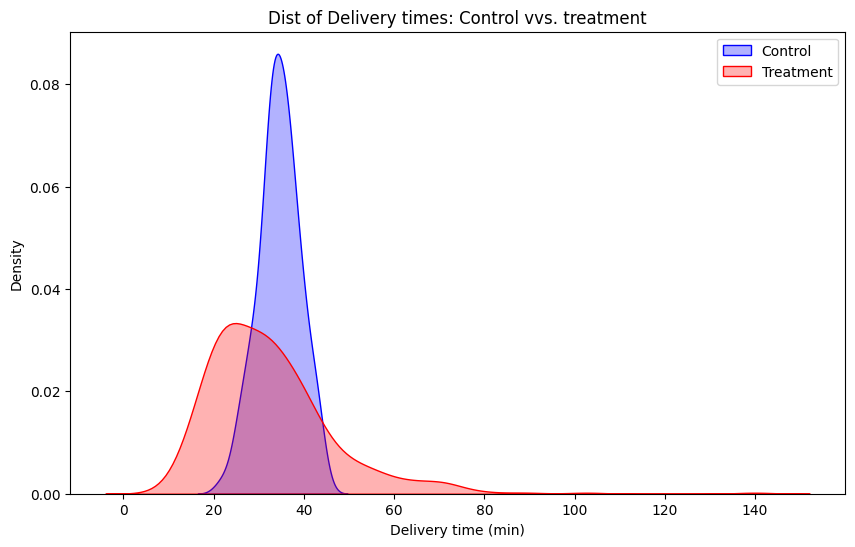

In [44]:
plt.figure(figsize=(10,6))
sns.kdeplot(control, fill=True, label = 'Control', color='blue', alpha= 0.3)
sns.kdeplot(treatment, fill=True, label = 'Treatment', color='red', alpha= 0.3)
plt.title('Dist of Delivery times: Control vvs. treatment')
plt.xlabel('Delivery time (min)')
plt.legend()
plt.show()

In [45]:
# Phase 3
# 3.1
df = pd.read_csv('swiftcart_loyalty.csv')

treated = df[df['subscriber'] ==1]['post_spend']
control = df[df['subscriber'] ==0]['post_spend']
sdo = treated.mean()-control.mean()
print(f"mean spending (subs): ${treated.mean():.2f}")
print(f"mean spending (non subs): ${control.mean():.2f}")
print(f"Naive SDO: ${sdo:.2f}")

mean spending (subs): $74.04
mean spending (non subs): $56.47
Naive SDO: $17.57


In [46]:
#3.2
covariates = ['pre_spend', 'account_age', 'support_tickets']
X = df[covariates]
Y = df['subscriber']
model = LogisticRegression()
model.fit(X,Y)
df['pscore'] = model.predict_proba(X)[:,1]

treated_df = df[df['subscriber'] ==1].copy()
control_df = df[df['subscriber'] ==0].copy()

nearn = NearestNeighbors(n_neighbors=1)
nearn.fit(control_df[['pscore']])
distances, indices = nearn.kneighbors(treated_df[['pscore']])

matched_control = control_df.iloc[indices.flatten()]

ATT = treated_df['post_spend'].mean() - matched_control['post_spend'].mean()
print(f"ATT: ${ATT:.2f}")
print(f"Naive SDO was: ${sdo:.2f}")




ATT: $9.91
Naive SDO was: $17.57


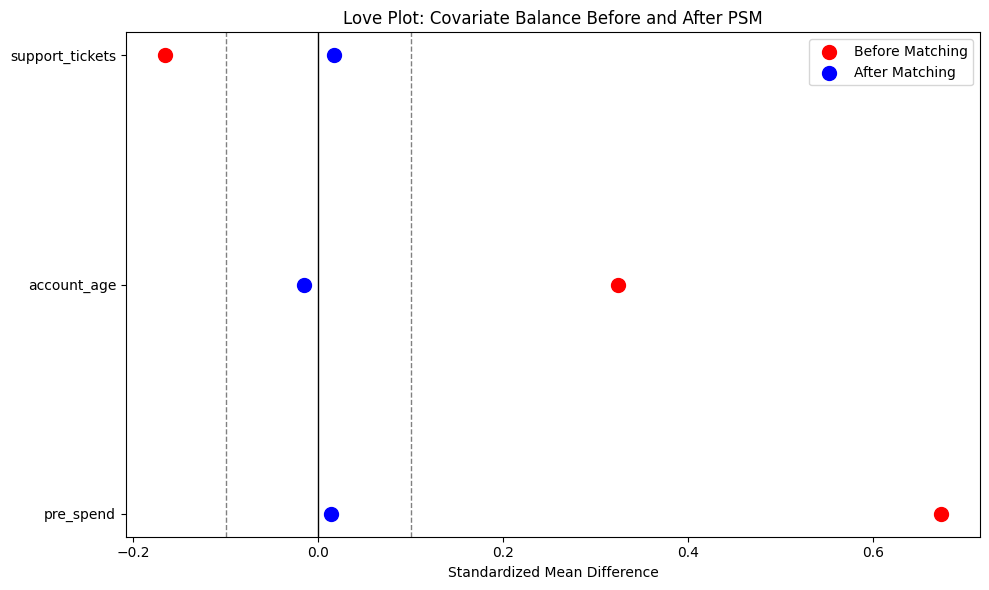

In [47]:
# Phase 4: Love Plot
df_unmatched = df.copy()
df_matched = pd.concat([treated_df, matched_control])

covariates = ['pre_spend', 'account_age', 'support_tickets']
smd_before = []
smd_after = []

for col in covariates:
    d1 = df_unmatched[df_unmatched['subscriber'] == 1][col]
    d0 = df_unmatched[df_unmatched['subscriber'] == 0][col]
    smd_before.append((d1.mean() - d0.mean()) / np.sqrt((d1.std()**2 + d0.std()**2) / 2))

    d1 = treated_df[col]
    d0 = matched_control[col]
    smd_after.append((d1.mean() - d0.mean()) / np.sqrt((d1.std()**2 + d0.std()**2) / 2))

plt.figure(figsize=(10, 6))
y_pos = range(len(covariates))
plt.scatter(smd_before, y_pos, color='red', s=100, label='Before Matching', zorder=3)
plt.scatter(smd_after, y_pos, color='blue', s=100, label='After Matching', zorder=3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=0.1, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=-0.1, color='gray', linestyle='--', linewidth=1)
plt.yticks(y_pos, covariates)
plt.xlabel('Standardized Mean Difference')
plt.title('Love Plot: Covariate Balance Before and After PSM')
plt.legend()
plt.tight_layout()
plt.show()